In [1]:
import geopandas as gpd
import json, math
import matplotlib.pyplot as plt
import pandas as pd
import konlpy
import re

# 한글 사용
from matplotlib import font_manager, rc, rcParams
def set_korea_font():
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    rcParams.update({'font.size': 11})
    rcParams['axes.unicode_minus'] = False  
set_korea_font()

# BASE

28.오산시_건물연면적_격자.geojson 격자표시  
31.오산시_법정경계(시군구).geojson -> 필요 없는 데이터  
32.오산시_행정경계(읍면동).geojson  
33.오산시_법정경계(읍면동).geojson

<AxesSubplot:>

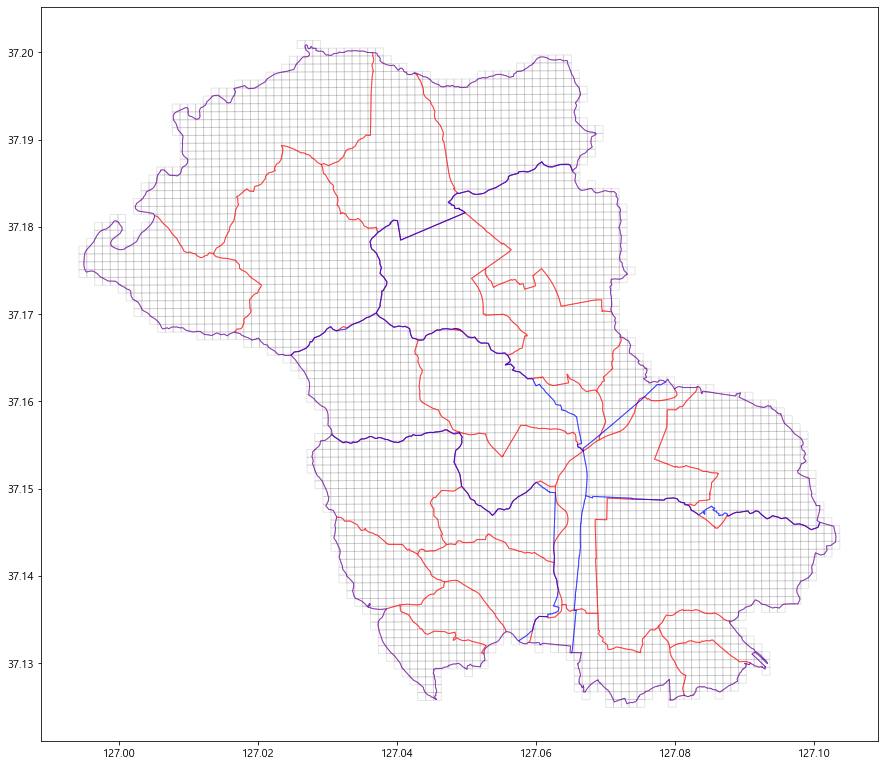

In [140]:
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(15,15))
df = gpd.read_file('../data/original/28.오산시_건물연면적_격자.geojson',encoding="utf-8")
df.plot(color=(0,0,0,0), edgecolor=(0,0,0,0.1),ax = ax)
df = gpd.read_file('../data/original/33.오산시_법정경계(읍면동).geojson',encoding="utf-8")
df.plot(color=(0,0,0,0), edgecolor=(1,0,0,0.5), ax = ax)
df = gpd.read_file('../data/original/32.오산시_행정경계(읍면동).geojson',encoding="utf-8")
df.plot(color=(0,0,0,0), edgecolor=(0,0,1,0.5), ax = ax)


34.오산시_지적도.geojson

<AxesSubplot:>

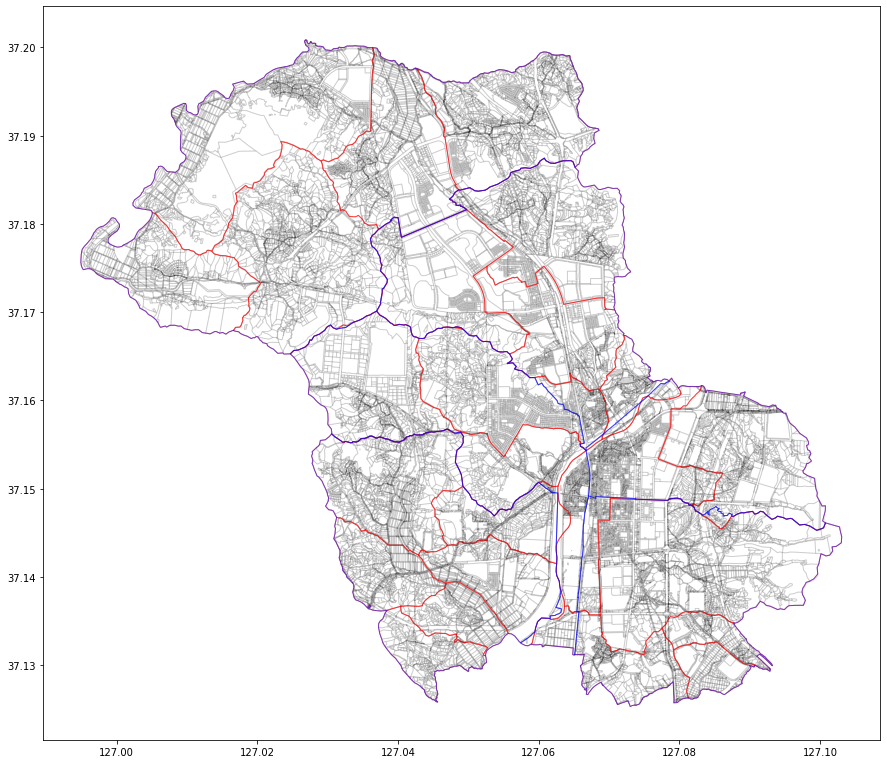

In [102]:
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(15,15))
df = gpd.read_file('../data/original/34.오산시_지적도.geojson',encoding="utf-8")
df.plot(color=(0,0,0,0), edgecolor=(0,0,0,0.1),ax = ax)
df = gpd.read_file('../data/original/33.오산시_법정경계(읍면동).geojson',encoding="utf-8")
df.plot(color=(0,0,0,0), edgecolor=(1,0,0,0.5),ax = ax)
df = gpd.read_file('../data/original/32.오산시_행정경계(읍면동).geojson',encoding="utf-8")
df.plot(color=(0,0,0,0), edgecolor=(0,0,1,0.5),ax = ax)

# 27.오산시_도로명주소_건물
이름|의미
--|--
'BDTYP_CD'| 건물용도코드 |
'BULD_NM'| 건축물 대장 상의 건물명 |
'BULD_NM_DC'| 상세건물명(101동 등) |
'BULD_SE_CD'| 건물구분코드('0'지상, '1'지하, '2'공중) |
'BUL_MAN_NO'| 건물일련번호 |
'EMD_CD'| 읍면동 코드 |
'GRO_FLO_CO'| 지상층수 |
'LNBR_MNNM'| 지번본번 |
'LNBR_SLNO'| 지번부번 |
'UND_FLO_CO'| 지하층수 |

1. 건물 사이즈 + 부지 크기 이용 -> 유동인구 숫자 파악  
2. 건물용도코드 이용해서 건물종류별 filter

In [192]:
df1 = gpd.read_file('../data/original/27.오산시_도로명주소_건물.geojson',encoding="utf-8")
df2 = gpd.read_file('../data/original/33.오산시_법정경계(읍면동).geojson',encoding="utf-8")

In [258]:
df1['BDTYP_CD'] = df1['BDTYP_CD'].astype(int)
lat = df1['geometry'].apply(lambda x: str(x[0]).strip("POLYGON( )").split(", ")[0].split()[0]).astype(float)
lon = df1['geometry'].apply(lambda x: str(x[0]).strip("POLYGON( )").split(", ")[0].split()[1]).astype(float)
tmp = pd.concat([lat,lon],axis=1)
tmp.columns = ["lat","lon"]
tmp["size"] = df1[['geometry','GRO_FLO_CO','UND_FLO_CO']].apply(lambda x: math.log((x[0].area * 10 * 1.0e10) * (1 + x[1] + x[2])),axis = 1)
tmp["color"] = df1['BDTYP_CD'].astype(int)

<AxesSubplot:xlabel='lat', ylabel='lon'>

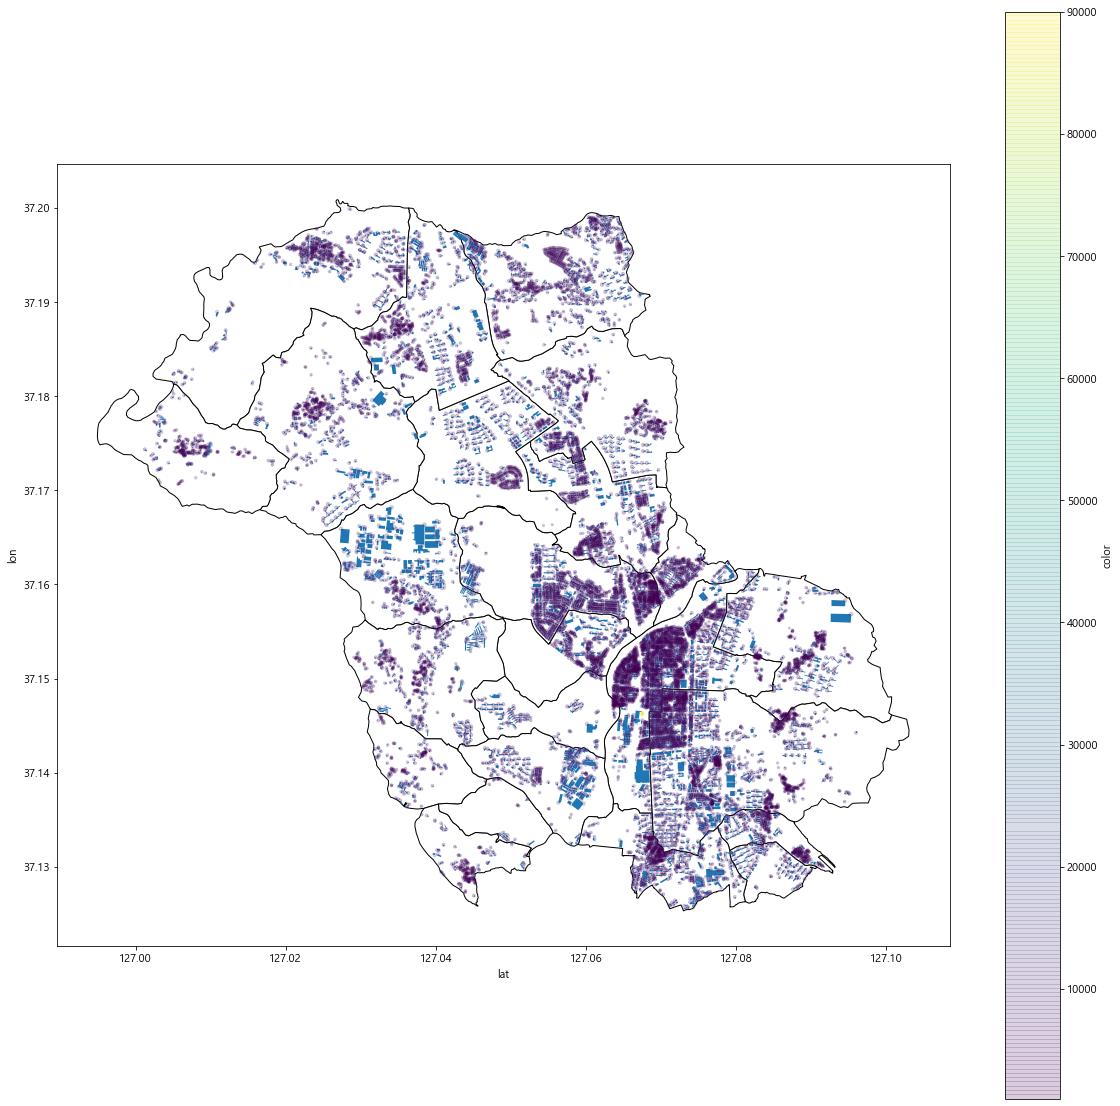

In [260]:
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(20,20))

df2.plot(ax = ax, color='white', edgecolor='black')
df1.plot(ax = ax)
tmp.plot.scatter(ax = ax, x="lat", y = "lon", s = "size",c = "color", colormap='viridis',
               alpha = 0.2)

# 29.오산시_체육시설현황.csv 


In [150]:
df = pd.read_csv("../data/original/29.오산시_체육시설현황.csv")
cate = list(df["시설구분명"].unique())
dic = dict(zip(cate,list(range(len(cate)))))
df["시설구분명_숫자"] = df["시설구분명"].map(dic)
df["시설구분명_숫자"] = df["시설구분명_숫자"].max() - df["시설구분명_숫자"]

<AxesSubplot:xlabel='설치위치_경도', ylabel='설치위치_위도'>

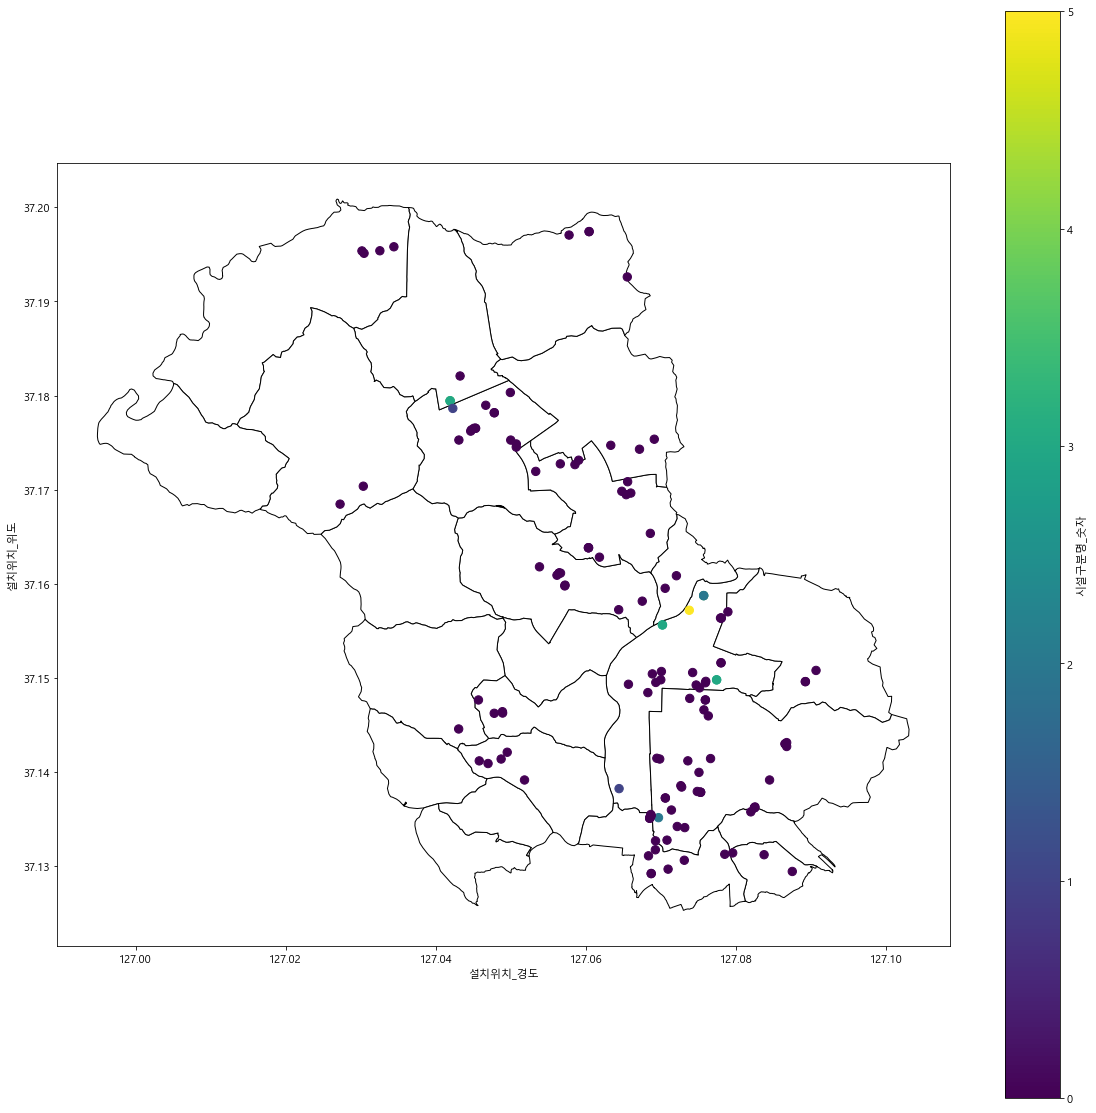

In [151]:
df1 = gpd.read_file('../data/original/27.오산시_도로명주소_건물.geojson',encoding="utf-8")
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(20,20))
df2.plot(ax = ax,color='white', edgecolor='black')
df.plot.scatter(ax = ax,x="설치위치_경도", y = "설치위치_위도", s = 70,c = "시설구분명_숫자", colormap='viridis')
# df

# 30.오산시_학원\_및\_교습소_현황.csv
1. 초등, 중등, 고등 나눔
2. 예체능, 단과학습반 나눔


In [50]:
df = pd.read_csv("../data/original/30.오산시_학원_및_교습소_현황.csv")

In [51]:
text_join = df["교습과정명"].str.cat(sep=" ")
filtered_content = re.sub(r'[^\d\s\w]', ' ', text_join)
filtered_content = re.sub(r'[\d PABCDEFGHIJKLMNOPGRSTUVWXYZQ]', ' ', filtered_content)
filtered_content = re.sub(r'[abcdefghijklmnopqrstuvwxyz*]', ' ', filtered_content)
twitter = konlpy.tag.Twitter()
twitter_morphs = twitter.pos(filtered_content)
word = set([i[0] for i in twitter_morphs if i[1] == "Noun"])

c:\users\ljw56\anaconda3\envs\geo\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [52]:
word
tmp = df["교습과정명"]

def check(x):
    try:
        for item in ["간호조무사", "가구", "가죽", "기능사", "네일아트", "다이어트", 
                          "세무","실무","실비","정보처리","회계","회사","고등"]:
            if item in x:
                return True
        return False
    except:
        return False
    
tmp[~tmp.apply(check)]

0                   음악
1                   미술
2                   보습
3       종합(국,수,사,과,논술)
4         피아노(체르니40이상)
             ...      
1781            피아노중급반
1782              국수사과
1783        피아노(고급주3회)
1784             피아노초급
1785             체르니30
Name: 교습과정명, Length: 1536, dtype: object

In [263]:
cate = list(df["업종구분명"].unique())
dic = dict(zip(cate,list(range(len(cate)))))
df["업종구분명_숫자"] = df["업종구분명"].map(dic)
df["업종구분명_숫자"] = df["업종구분명_숫자"].max() - df["업종구분명_숫자"]

<AxesSubplot:xlabel='시설위치_경도', ylabel='시설위치_위도'>

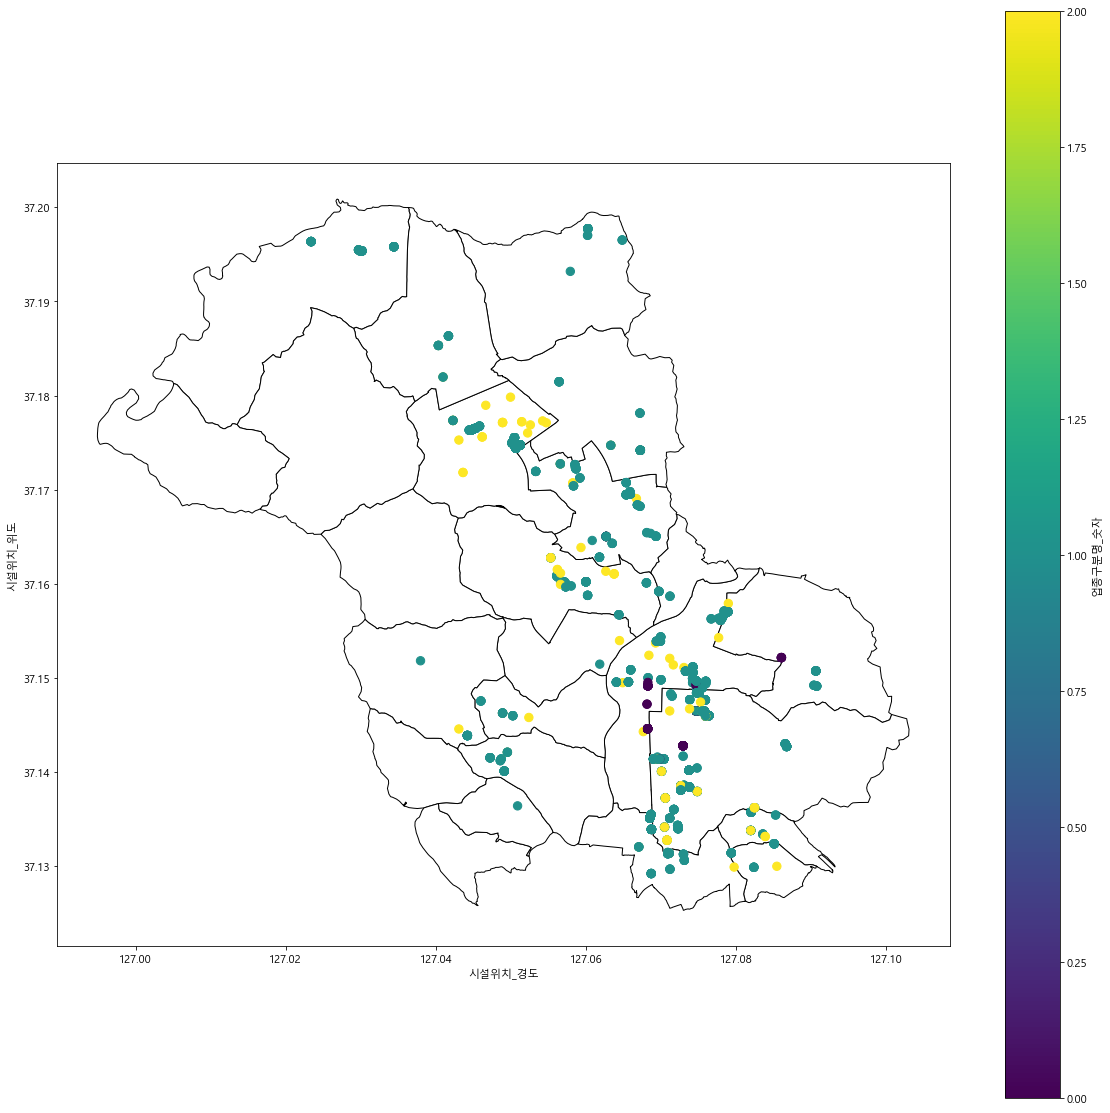

In [266]:
df1 = gpd.read_file('../data/original/27.오산시_도로명주소_건물.geojson',encoding="utf-8")
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(20,20))
df2.plot(ax = ax,color='white', edgecolor='black')
df.plot.scatter(ax = ax,x="시설위치_경도", y = "시설위치_위도", s = 70,c = "업종구분명_숫자", colormap='viridis')
# df